In [83]:
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON

In [ ]:
api_key = ''

In [85]:
channel_ids = [
    "UC7cs8q-gJRlGwj4A8OmCmXg",  # Alex The Analyst
    "UCh9nVJoWXmFb7sLApWGcLPQ",  # codebasics
    "UC8uU_wruBMHeeRma49dtZKA",  # Chandoo
]

In [86]:
api_service_name = "youtube"
api_version = "v3"

youtube = build(
    api_service_name, api_version,developerKey=api_key)

request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=",".join(channel_ids)
)
response = request.execute()
JSON(response)

<IPython.core.display.JSON object>

In [87]:
def getChannelStats(youtube, channel_ids):
    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=",".join(channel_ids)
    )
    response = request.execute()

    for item in response['items']:
        data = {
            "Channel_name": item["snippet"]["title"],
            "Subscribers": item["statistics"]["subscriberCount"],
            "Views": item["statistics"]["viewCount"],
            "PublishedAt": item["snippet"]["publishedAt"],
            "Country": item.get("snippet", {}).get("country", "N/A"),
            "Total_videos": item["statistics"]["videoCount"],
            "playlist_id": item["contentDetails"]["relatedPlaylists"]["uploads"]
        }

        all_data.append(data)

    return pd.DataFrame(all_data)

In [88]:
df = getChannelStats(youtube, channel_ids)

In [89]:
df

,Channel_name,Subscribers,Views,PublishedAt,Country,Total_videos,playlist_id
0,codebasics,1280000,130938442,2015-11-07T17:29:46Z,US,1052,UUh9nVJoWXmFb7sLApWGcLPQ
1,Chandoo,760000,57436324,2009-05-02T06:44:42Z,NZ,522,UU8uU_wruBMHeeRma49dtZKA
2,Alex The Analyst,1060000,50038841,2020-01-08T05:04:24.970712Z,US,362,UU7cs8q-gJRlGwj4A8OmCmXg


In [90]:
df.columns

Index(['Channel_name', 'Subscribers', 'Views', 'PublishedAt', 'Country',
       'Total_videos', 'playlist_id'],
      dtype='object')

In [91]:
df.dtypes

Channel_name    object
Subscribers     object
Views           object
PublishedAt     object
Country         object
Total_videos    object
playlist_id     object
dtype: object

In [92]:
df['Subscribers'] = pd.to_numeric(df['Subscribers'], errors='coerce')
df['Views'] = pd.to_numeric(df['Views'], errors='coerce')
df['Total_videos'] = pd.to_numeric(df['Total_videos'], errors='coerce')

In [93]:
from dateutil import parser

df['PublishedAt'] = df['PublishedAt'].apply(lambda x: parser.parse(x))

In [94]:
df.dtypes

Channel_name                     object
Subscribers                       int64
Views                             int64
PublishedAt     datetime64[ns, tzutc()]
Country                          object
Total_videos                      int64
playlist_id                      object
dtype: object

In [95]:
df['PublishedAt']

0          2015-11-07 17:29:46+00:00
1          2009-05-02 06:44:42+00:00
2   2020-01-08 05:04:24.970712+00:00
Name: PublishedAt, dtype: datetime64[ns, tzutc()]

### Feature Enginneering

In [96]:
from datetime import datetime

now = datetime.now(tz=df['PublishedAt'].dt.tz)
df['channel_age_years'] = (now - df['PublishedAt']).dt.days // 365

In [97]:
df

,Channel_name,Subscribers,Views,PublishedAt,Country,Total_videos,playlist_id,channel_age_years
0,codebasics,1280000,130938442,2015-11-07 17:29:46+00:00,US,1052,UUh9nVJoWXmFb7sLApWGcLPQ,9
1,Chandoo,760000,57436324,2009-05-02 06:44:42+00:00,NZ,522,UU8uU_wruBMHeeRma49dtZKA,16
2,Alex The Analyst,1060000,50038841,2020-01-08 05:04:24.970712+00:00,US,362,UU7cs8q-gJRlGwj4A8OmCmXg,5


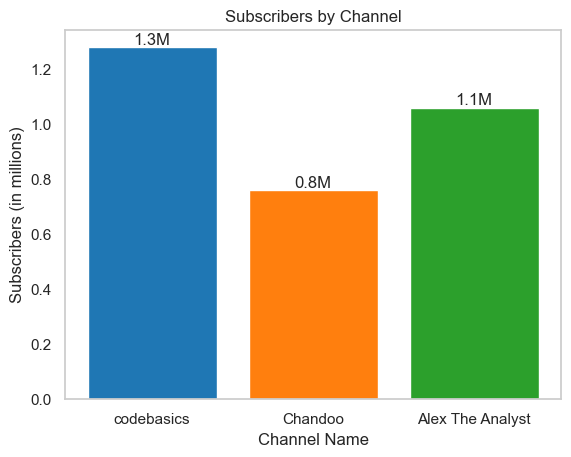

In [113]:
import matplotlib.pyplot as plt

df['Subscribers_million'] = df['Subscribers'] / 1_000_000
channels = df['Channel_name']
subs = df['Subscribers_million']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.bar(channels, subs, color=colors)
plt.title('Subscribers by Channel')
plt.ylabel('Subscribers (in millions)')
plt.xlabel('Channel Name')

for i, val in enumerate(subs):
    plt.text(i, val, f'{val:.1f}M', ha='center', va='bottom')

plt.grid(False)
plt.show()

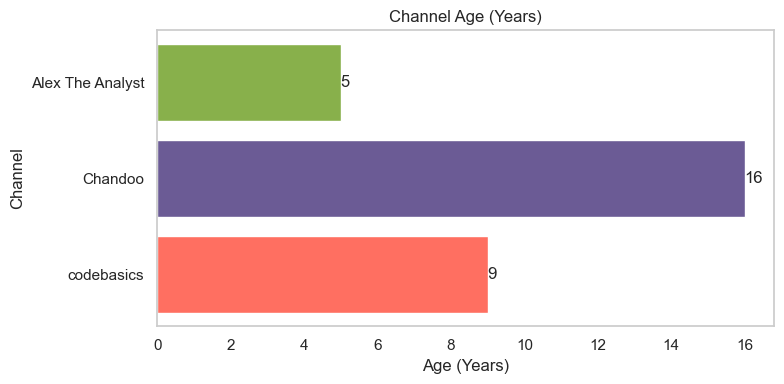

In [112]:
channels = df['Channel_name']
ages = df['channel_age_years']
colors = ['#FF6F61', '#6B5B95', '#88B04B']

plt.figure(figsize=(8, 4))
bars = plt.barh(channels, ages, color=colors)

plt.title('Channel Age (Years)')
plt.xlabel('Age (Years)')
plt.ylabel('Channel')

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
             va='center', ha='left')

plt.grid(False)
plt.tight_layout()
plt.show()


In [114]:
df.to_csv('channels_data.csv', index=False)